What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and attribute any extra to a different, missing process?

If the hybrid process is drawing equally on the NH4+ and NO2- pools, should we calculate the total rate not as the sum of rate constants times substrates, but rather as a minimum of whichever substrate is the limiting reagent?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
from collections import namedtuple

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [2]:
### READ IN TRAINING DATA ###
PS2SCM15NO2 = sc.grid_data(filename=f'{sc.datapath()}00_incubationdata.csv',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

In [3]:
### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NO2-")

In [4]:
### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

In [6]:
### MODEL PARAMS ###
(dt, T, times) = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NO2) 

tr

state variable arrays initialized!

In [7]:
### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

In [8]:
x

[0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 3.944363997256793e-08]

In [9]:
def modelv1(x, tracers):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid] = x

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid = khybrid*(tracers.nh4_14[iT]+tracers.nh4_15[iT])*(tracers.no2_14[iT]+tracers.no2_15[iT])

        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -bgc.kNH4TONO2*tracers.nh4_14[iT]

            -Jnitrification*(1-tracers.afnh4[iT,:])
            -Jhybrid*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -bgc.kNH4TONO2/isos.alpha15NH4TONO2*tracers.nh4_15[iT]

            -Jnitrification*tracers.afnh4[iT,:]
            -Jhybrid*tracers.afnh4[iT,:])

        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            bgc.kNH4TONO2*tracers.nh4_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]

            -Jdenitno2*(1-tracers.afno2[iT,:])
            -Jhybrid*(1-tracers.afno2[iT,:]))

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            bgc.kNH4TONO2/isos.alpha15NH4TONO2*tracers.nh4_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]

            -Jdenitno2*(tracers.afno2[iT,:])
            -Jhybrid*tracers.afno2[iT,:])

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]

            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]

            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid = Jhybrid/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno2[iT], tracers.afnh4[iT])

        p46hybrid = p1
        p45ahybrid = p2 # (p2+p3)/2
        p45bhybrid = p3 # (p2+p3)/2
        p44hybrid = p4

        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid*p46hybrid
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid*p45ahybrid
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid*p45bhybrid
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid*p44hybrid
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [10]:
def objective(x, tracers):
    
    tracers = modelv1(x, tracers)
    
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))
    
    return cost

In [11]:
objective(x, tr)

1.095125894228893

## Optimization

In [14]:
xguess = x

xguess

[0.0, 2.8050367317752543e-09, 2.633772229350046e-09, 3.944363997256793e-08]

In [15]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(4)*(r_max - r_min)

pt

array([0.00000000e+00, 2.84221242e-09, 2.96015389e-09, 3.72592379e-08])

In [17]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 111
Solution: f([0.00000000e+00 6.16447340e-09 4.12922517e-09 8.67329911e-08]) = 0.37530


In [18]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, args = tr, method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, tr)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 117
Solution: f([0.00000000e+00 6.14949623e-09 4.13259902e-09 8.67231308e-08]) = 0.37529


In [19]:
objective(result.x, tr)

0.3752892043802014

In [20]:
result.x

array([0.00000000e+00, 6.14949623e-09, 4.13259902e-09, 8.67231308e-08])

# Next:

- use Tracers object as input for the postprocessing below
- create postprocessing function

In [17]:
### STATE VARIABLE ARRAYS & MODEL PARAMS ###
(dt, T, times,
 n2o_44, n2o_45a, n2o_45b, n2o_46,
 nh4_14, nh4_15, no2_14, no2_15, no3_14, no3_15,
 n2_28, n2_29, n2_30,
 afnh4, afno2, afno3) = sc.modelparams(bgc, PS2SCM15NO2)


x = result.x

### UNPACK X ###
[knitrification, kdenitno2, kdenitno3, khybrid] = x

### TIME STEPPING ###
for iT in range(T-1):

    Jhybrid = khybrid*(nh4_14[iT]+nh4_15[iT])*(no2_14[iT]+no2_15[iT])

    Jnitrification = knitrification*((nh4_14[iT]+nh4_15[iT])**2)
    Jdenitno2 = kdenitno2*((no2_14[iT]+no2_15[iT])**2)
    Jdenitno3 = kdenitno3*((no3_14[iT]+no3_15[iT])**2)

    # update substrate values
    nh4_14[iT+1,:] = nh4_14[iT,:] + dt*(
        -bgc.kNH4TONO2*nh4_14[iT]

        -Jnitrification*(1-afnh4[iT,:])
        -Jhybrid*(1-afnh4[iT,:]))

    nh4_15[iT+1,:] = nh4_15[iT,:] + dt*(
        -bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]

        -Jnitrification*afnh4[iT,:]
        -Jhybrid*afnh4[iT,:])

    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])

    no2_14[iT+1,:] = no2_14[iT,:] + dt*(
        bgc.kNH4TONO2*nh4_14[iT]
        +bgc.kNO3TONO2*no3_14[iT]
        -bgc.kNO2TONO3*no2_14[iT]

        -Jdenitno2*(1-afno2[iT,:])
        -Jhybrid*(1-afno2[iT,:]))

    no2_15[iT+1,:] = no2_15[iT,:] + dt*(
        bgc.kNH4TONO2/isos.alpha15NH4TONO2*nh4_15[iT]
        +bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]
        -bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]

        -Jdenitno2*(afno2[iT,:])
        -Jhybrid*afno2[iT,:])

    no3_14[iT+1,:] = no3_14[iT,:] + dt*(
        bgc.kNO2TONO3*no2_14[iT]
        -bgc.kNO3TONO2*no3_14[iT]

        -Jdenitno3*(1-afno3[iT,:]))

    no3_15[iT+1,:] = no3_15[iT,:] + dt*(
        bgc.kNO2TONO3/isos.alpha15NO2TONO3*no2_15[iT]
        -bgc.kNO3TONO2/isos.alpha15NO3TONO2*no3_15[iT]

        -Jdenitno3*afno3[iT,:])

    # recalculate atom fractions at each time step
    afnh4[iT+1,:] = nh4_15[iT+1,:]/(nh4_14[iT+1,:] + nh4_15[iT+1,:])
    afno2[iT+1,:] = no2_15[iT+1,:]/(no2_14[iT+1,:] + no2_15[iT+1,:])
    afno3[iT+1,:] = no3_15[iT+1,:]/(no3_14[iT+1,:] + no3_15[iT+1,:])

    # calculate total rates of N2O production from substrates

    total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
    total_denit_no2 = Jdenitno2/2
    total_denit_no3 = Jdenitno3/2
    total_hybrid = Jhybrid/2

    # calculate probabilities of isotopomer formation

    p1, p2, p3, p4 = sc.binomial(afno2[iT], afnh4[iT])

    p46hybrid = p1
    p45ahybrid = p2 # (p2+p3)/2
    p45bhybrid = p3 # (p2+p3)/2
    p44hybrid = p4

    p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(afnh4[iT], afnh4[iT])
    p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(afno2[iT], afno2[iT])
    p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(afno3[iT], afno3[iT])

    # update N2O values
    n2o_46[iT+1,:] = n2o_46[iT,:] + dt*(
        +total_hybrid*p46hybrid
        +total_nitrification*p46nh4
        +total_denit_no2*p46no2
        +total_denit_no3*p46no3
        -bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

    n2o_45a[iT+1, :] = n2o_45a[iT,:] + dt*(
        +total_hybrid*p45ahybrid
        +total_nitrification*p45anh4
        +total_denit_no2*p45ano2
        +total_denit_no3*p45ano3
        -bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT])

    n2o_45b[iT+1, :] = n2o_45b[iT,:] + dt*(
        +total_hybrid*p45bhybrid
        +total_nitrification*p45bnh4
        +total_denit_no2*p45bno2
        +total_denit_no3*p45bno3
        -bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2o_44[iT+1,:] = n2o_44[iT,:] + dt*(
        +total_hybrid*p44hybrid
        +total_nitrification*p44nh4
        +total_denit_no2*p44no2
        +total_denit_no3*p44no3
        -bgc.kN2OCONS*n2o_44[iT])

    # update N2 values

    n2_28[iT+1,:] = n2_28[iT,:] + dt*(bgc.kN2OCONS*n2o_44[iT])

    n2_29[iT+1,:] = n2_29[iT,:] + dt*(
        bgc.kN2OCONS/isos.alpha15N2OatoN2*n2o_45a[iT]
        +bgc.kN2OCONS/isos.alpha15N2ObtoN2*n2o_45b[iT])

    n2_30[iT+1,:] = n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*n2o_46[iT])

#calculate cost
cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = n2o_44,
                modeled_45a = n2o_45a,
                modeled_45b = n2o_45b,
                modeled_46 = n2o_46,
                weights = np.array([1,10,10,10]))

In [18]:
# one thing that's really useful is that we can pass the "binomial" function full arrays,
# not just single values...

pd.DataFrame(np.array(sc.binomial(afno2, afno2)).reshape(4,1000))

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.988521,0.988510,0.988500,0.988490,0.988479,0.988469,0.988459,0.988448,0.988438,0.988428,...,0.978288,0.978278,0.978267,0.978257,0.978247,0.978236,0.978226,0.978216,0.978205,0.978195
1,0.005723,0.005728,0.005733,0.005738,0.005744,0.005749,0.005754,0.005759,0.005764,0.005769,...,0.010796,0.010802,0.010807,0.010812,0.010817,0.010822,0.010827,0.010832,0.010837,0.010842
2,0.005723,0.005728,0.005733,0.005738,0.005744,0.005749,0.005754,0.005759,0.005764,0.005769,...,0.010796,0.010802,0.010807,0.010812,0.010817,0.010822,0.010827,0.010832,0.010837,0.010842
3,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000034,0.000034,0.000034,...,0.000119,0.000119,0.000119,0.000119,0.000120,0.000120,0.000120,0.000120,0.000120,0.000120


In [19]:
### CALCULATE OUTPUT ###

### ISOTOPE CONSTANTS ###
R15std = 0.00367647 # air N2
R18std = 0.00200517 # VSMOW


nh4_concentration = pd.DataFrame(nh4_14+nh4_15, columns={'[NH4+]_nM'})
d15nh4 = pd.DataFrame((((nh4_15/(nh4_14))/R15std)-1)*1000, columns={'d15NH4+'})
afnh4_df = pd.DataFrame(afnh4, columns={'AFNH4+'})

no3_concentration = pd.DataFrame(no3_14+no3_15, columns={'[NO3-]_nM'})
d15no3 = pd.DataFrame((((no3_15/(no3_14))/R15std)-1)*1000, columns={'d15NO3-'})
afno3_df = pd.DataFrame(afno3, columns={'AFNO3-'})

no2_concentration = pd.DataFrame(no2_14+no2_15, columns={'[NO2-]_nM'})
d15no2 = pd.DataFrame((((no2_15/(no2_14))/R15std)-1)*1000, columns={'d15NO2-'})
afno2_df = pd.DataFrame(afno2, columns={'AFNO2-'})


n2o_concentration = pd.DataFrame(n2o_44+n2o_45a+n2o_45b+n2o_46, columns={'[N2O]_nM'})

n2_concentration = pd.DataFrame(n2_28+n2_29+n2_30, columns = {'[N2]_nM'})


d15Na = pd.DataFrame((((n2o_45a/(n2o_44))/R15std)-1)*1000, columns={'d15N2Oa'})
d15Nb = pd.DataFrame((((n2o_45b/(n2o_44))/R15std)-1)*1000, columns={'d15N2Ob'})
d18O = pd.DataFrame((((n2o_46/(n2o_44))/R15std)-1)*1000, columns={'d18O'})

n2o_44 = pd.DataFrame(n2o_44, columns={'[N2O_44]_nM'})
n2o_45a = pd.DataFrame(n2o_45a, columns={'[N2O_45a]_nM'})
n2o_45b = pd.DataFrame(n2o_45b, columns={'[N2O_45b]_nM'})
n2o_46 = pd.DataFrame(n2o_46, columns={'[N2O_46]_nM'})

output = nh4_concentration.join([
    d15nh4,afnh4_df,
    no3_concentration, d15no3, afno3_df,
    no2_concentration, d15no2, afno2_df,
    n2o_concentration, n2_concentration, n2o_44, n2o_45a, n2o_45b, n2o_46,
    d15Na, d15Nb, d18O])

output["Incubation_time_hrs"] = output.index/1000*24

output['check_mass_conservation'] = output.loc[:,['[NH4+]_nM',
                                                  '[NO3-]_nM',
                                                  '[NO2-]_nM',
                                                  '[N2O]_nM',
                                                  '[N2]_nM',
                                                  '[N2]_nM']].sum(axis=1)
                                                  

In [20]:
output

,[NH4+]_nM,d15NH4+,AFNH4+,[NO3-]_nM,d15NO3-,AFNO3-,[NO2-]_nM,d15NO2-,AFNO2-,[N2O]_nM,[N2]_nM,[N2O_44]_nM,[N2O_45a]_nM,[N2O_45b]_nM,[N2O_46]_nM,d15N2Oa,d15N2Ob,d18O,Incubation_time_hrs,check_mass_conservation
0,550.000000,0.636349,0.003665,26480.000000,15.250000,0.003719,4827.890000,4.698056e+07,0.994244,17.473512,0.000000,17.287897,0.079703,0.067088,0.038824,254.006459,55.539573,-389.164748,0.000,31875.363512
1,549.999231,0.636370,0.003665,26480.046644,16.012094,0.003721,4827.840631,4.693790e+07,0.994239,17.474166,0.000978,17.288365,0.079818,0.067090,0.038893,255.781698,55.542676,-388.094293,0.024,31875.362629
2,549.998462,0.636391,0.003665,26480.093288,16.774177,0.003724,4827.791263,4.689532e+07,0.994233,17.474819,0.001957,17.288832,0.079933,0.067092,0.038962,257.556781,55.545846,-387.023990,0.048,31875.361746
3,549.997693,0.636412,0.003665,26480.139930,17.536249,0.003727,4827.741896,4.685282e+07,0.994228,17.475473,0.002935,17.289300,0.080048,0.067094,0.039031,259.331708,55.549086,-385.953838,0.072,31875.360863
4,549.996924,0.636433,0.003665,26480.186572,18.298310,0.003730,4827.692529,4.681039e+07,0.994223,17.476127,0.003914,17.289767,0.080163,0.067097,0.039100,261.106480,55.552394,-384.883837,0.096,31875.359980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,549.236445,0.657380,0.003665,26526.007986,768.107601,0.006458,4779.168345,2.458605e+07,0.989058,18.107357,0.991283,17.739331,0.192210,0.071143,0.104673,1947.190971,90.850784,604.968259,23.880,31874.502698
996,549.235679,0.657401,0.003665,26526.053821,768.858800,0.006461,4779.119779,2.457419e+07,0.989053,18.107978,0.992297,17.739771,0.192321,0.071149,0.104736,1948.822528,90.917099,605.899534,23.904,31874.501851
997,549.234913,0.657422,0.003665,26526.099656,769.609988,0.006464,4779.071215,2.456235e+07,0.989048,18.108598,0.993310,17.740211,0.192433,0.071155,0.104800,1950.453951,90.983473,606.830680,23.928,31874.501003
998,549.234148,0.657444,0.003665,26526.145490,770.361166,0.006467,4779.022651,2.455051e+07,0.989043,18.109219,0.994324,17.740651,0.192544,0.071162,0.104863,1952.085240,91.049906,607.761697,23.952,31874.500156


In [21]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

31874.499308528488
31875.363511943997


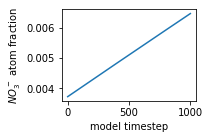

In [22]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no3-atomfraction.pdf")

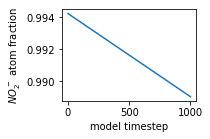

In [23]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
plt.savefig("figures/no2-atomfraction.pdf")

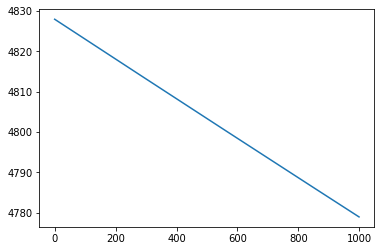

In [24]:
plt.plot(output['[NO2-]_nM'])

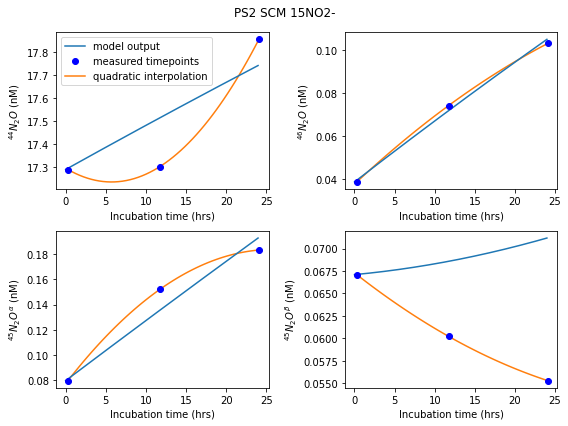

In [25]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2.pdf")